In [1]:
from PIL import Image
from bisect import bisect
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import linear_model, preprocessing
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pathlib as pl
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
work_dir = pl.Path('data')
cygnss = pickle.load(open(work_dir / 'cygnss.pkl', 'rb'))
ddms = np.array(cygnss['ddm'])
lats = np.array(cygnss['lat_deg'])
lons = np.array(cygnss['lon_deg'])

In [3]:
target_file = work_dir / 'target.pkl'

if not target_file.exists():
    mask = np.array(Image.open(work_dir / 'water.tif'), dtype=np.uint8)
    mask[mask > 0] = 1
    wlons = np.linspace(extent[0], extent[1], mask.shape[1])
    wlats = np.linspace(extent[2], extent[3], mask.shape[0])
    ilons = [bisect(wlons, o) for o in lons]
    ilats = [mask.shape[0] - bisect(wlats, a) for a in lats]
    target = np.array([mask[a, o] for a, o in zip(ilats, ilons)])
    pickle.dump(target, open(target_file, 'wb'))
else:
    target = pickle.load(open(target_file, 'rb'))

In [4]:
# Remove negative values (-9999 is the invalid flag)
positive = np.array([i for i, d in enumerate(ddms) if np.all(d > 0)])
ddms = ddms[positive]
target = target[positive]
lats = lats[positive]
lons = lons[positive]
# Shuffle data together
ddms, target, lats, lons = shuffle(ddms, target, lats, lons, random_state=0)
ddms = ddms.reshape(ddms.shape[0], -1)

In [5]:
def make_map(background=False, coastline=0):
    """Create a plot for displaying samples geographically.

    :param background: Whether to add a terrain background image.
    :param coastline: The 'zorder' of the coastline (0 to omit)
    :returns: subplot
    :rtype: TODO

    """
    # Base
    fig, axes = plt.subplots()
    extent = (110, 120, 0, 10)
    axes.set_xlim([extent[0], extent[1]])
    axes.set_ylim([extent[2], extent[3]])
    yticks = [1, 3, 5, 7, 9]
    xticks = [111, 113, 115, 117, 119]
    axes.set_yticks(yticks)
    axes.set_xticks(xticks)
    axes.set_yticklabels([fr'{i}$^\circ$N' for i in yticks])
    axes.set_xticklabels([fr'{i}$^\circ$E' for i in xticks])
    axes.set_aspect('equal')

    # Coastline?
    if coastline != 0:
        img = mpimg.imread('images/coast.png').astype(int)
        zero = np.where(img == [0, 0, 0, 0])
        mask = np.full((img.shape[0], img.shape[1]), np.nan)
        mask[zero[0], zero[1]] = 1
        axes.imshow(mask,
                    origin='upper',
                    extent=extent,
                    zorder=coastline,
                    cmap=ListedColormap([(0, 0, 0, 1), (1, 1 ,1 ,1)]))

    # Background?
    if background:
        axes.imshow(mpimg.imread('images/blank_terrain.png'),
                    origin='upper',
                    extent=extent,
                    zorder=1,)

    return axes

In [6]:
def plot_ddm_stats(predictor, correct, water, land):
    ims = []
    ddm_water = predictor[water]
    ims.append(np.log10(np.mean(ddm_water, axis=0).reshape(17, 11)).copy())
    tpi = np.intersect1d(water, np.where(correct)[0])
    tpd = predictor[tpi]
    ims.append(np.log10(np.mean(tpd, axis=0).reshape(17, 11)).copy())
    fni = np.intersect1d(land, np.where(~correct)[0])
    fnd = predictor[fni]
    ims.append(np.log10(np.mean(fnd, axis=0).reshape(17, 11)).copy())
    fpi = np.intersect1d(water, np.where(~correct)[0])
    fpd = predictor[fpi]
    ims.append(np.log10(np.mean(fpd, axis=0).reshape(17, 11)).copy())
    tni = np.intersect1d(land, np.where(correct)[0])
    tnd = predictor[tni]
    ims.append(np.log10(np.mean(tnd, axis=0).reshape(17, 11)).copy())
    ddm_land = predictor[land]
    ims.append(np.log10(np.mean(ddm_land, axis=0).reshape(17, 11)).copy())
    titles = ['Positive', 'True Positive', 'False Positive', 'False Negative',
              'True Negative', 'Negative']
    fig, axes = plt.subplots(1, len(ims))
    for ax, im, ti in zip(axes, ims, titles):
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(ti, fontsize=7)
        ax.patch.set_visible(False)
        ax.imshow(im, cmap='jet', vmin=np.amin(ims[0]), vmax=np.amax(ims[0]))
    plt.tight_layout()

In [7]:
n = ddms.shape[0]
num_train = int(0.8 * n)
Xtr = ddms[:num_train]
ytr = target[:num_train]
Xts = ddms[num_train:]
yts = target[num_train:]
lats_ts = lats[num_train:]
lons_ts = lons[num_train:]
water_ts = np.where(yts == 1)[0]
land_ts = np.where(yts == 0)[0]

In [8]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [10]:
#Fitting XGBoost to the training set 

from xgboost import XGBClassifier
classifier = XGBClassifier(max_depth=4)
classifier.fit(Xtr, ytr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
## Predicting the Test set results
y_pred_train = classifier.predict(Xtr)
y_pred = classifier.predict(Xts)

In [12]:
acc_train = np.mean(y_pred_train == ytr)
acc = np.mean(y_pred == yts)
print('Accuracy on train data = {0:.4f}'.format(acc_train))
print('Accuracy on test data = {0:.4f}'.format(acc))

Accuracy on train data = 0.9278
Accuracy on test data = 0.9153


In [17]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = Xtr, y = ytr, cv = 10)
accuracies.mean()
accuracies.std()

0.002414441480562037

In [18]:
print(accuracies)
accuracies.mean

[0.91293214 0.91459667 0.9128041  0.91190781 0.91690141 0.91702945
 0.91075544 0.91035984 0.91356128 0.90971955]


<function ndarray.mean>

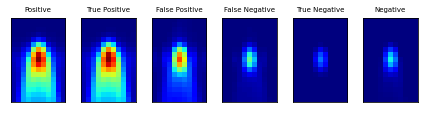

In [19]:
correct = y_pred.astype(int) == yts
plot_ddm_stats(Xts, correct, water_ts, land_ts)
plt.show()
plt.close()

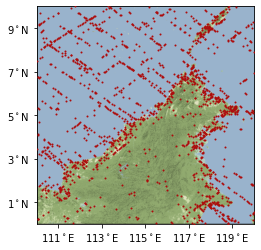

In [20]:
axes = make_map(background=True)
axes.scatter(lons_ts[~correct], lats_ts[~correct], s=1, c='#ad0c0c', zorder=4)
plt.show()
plt.close()

In [21]:
#Save the model
import pickle
file_name = 'xgboost.sav'
pickle.dump(classifier,open(file_name,'wb'))